# Problem 3: Least squares and regression (3pts)
### <div align="right"> &copy; Ostap Dyhdalovych and Volodymyr Kuchynskyi, 2022 </div>

## Completed by:   
*   Nazar Andrushko
*   Roman Kovalchuk



#### The aim of this assignment is to understand how the idea of the least square solution for system of linear equations can be used to fit and model data with non-linear dependence. The task is to suggest a good time series model for real data of temperature over a long period of time

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


## 1. Least squares and simple linear regression (0.3 pts)

#### Least squares quick refresher
Consider an ***inconsistent*** system of linear equations $$ A\mathbf{x} = \mathbf{y}$$
Inconsistency means that no solution $\mathbf{x}$ exists, i.e. $\mathbf{y} \notin \mathbf{Col}{(A)}$. However, at least one ***least squares solution*** of such system always exists, and it is ***the best approximate solution***. The least squares solution $\mathbf{\hat{x}}$ is the solution to the ***normal equation***
$$A^{\top}A\mathbf{\hat{x}} = A^{\top}\mathbf{y}$$
if the columns of $A$ are linearly independent, then $A^\top A$ is invertible, and the solution is
$$ \mathbf{\hat{x}} = (A^{\top}A)^{-1} A^{\top}\mathbf{y}$$


### **1.1 (0.3 pts)**

We start with the simplest case of linear (affine) model, in which both the  predictor $x$ and the responce $y$ are scalar, and we are looking for the linear dependence
$$ f(x) = a x + b $$
Fill in the missing parts in the code below

> **_NOTE:_** you have to implement the least squares solution by solving the normal equation using basic numpy operations and functions. The use of preexisting solvers, such as `linalg.lstsq` from numpy or from any other library is forbidden.

In [63]:
def solve_least_squares(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Args:
        x: 1D array of inputs (predictors)
        y: 1D array of outcomes (responses)
    Returns:
        array(slope, intercept): coeff of the linear function
    """
    assert x.ndim == 1
    assert y.ndim == 1
    assert x.shape[0] == y.shape[0]

    # Calculate means
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate slope
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)

    # Calculate intercept
    intercept = y_mean - slope * x_mean

    return np.array([slope, intercept])

In [64]:
def test_solve_least_squares():
    x = np.arange(1, 10)
    y = 3*x + 1

    coeffs = solve_least_squares(x, y)
    # print(coeffs)
    assert np.isclose(coeffs, np.array([3, 1])).all(), 'Incorrect coefficients computed'
    print("TEST 1: SUCCESS")

test_solve_least_squares()

TEST 1: SUCCESS


## 2. Dataset
We will analyze the dataset of average monthly temperatures from 1850 till 2015

In [75]:
temp_data = pd.read_csv("Task3_data.csv")
temp_data["date"] = pd.to_datetime(temp_data["date"])
# temp_data["month"] = temp_data['date'].map(lambda x: (x.year*12 + x.month))
temp_data.describe()

,date,avg_temp
count,1992,1992.000000
mean,1932-12-16 00:11:33.975903744,8.571583
min,1850-01-01 00:00:00,0.404000
25%,1891-06-23 12:00:00,4.430000
50%,1932-12-16 12:00:00,8.850500
75%,1974-06-08 12:00:00,12.858500
max,2015-12-01 00:00:00,15.482000
std,NaN,4.263193


In [76]:
year_data = temp_data.groupby(temp_data['date'].map(lambda x: x.year)).mean()
year_data.reset_index(drop=True, inplace=True)
year_data.columns = ['year', 'avg_temp']
year_data['year'] = year_data['year'].map(lambda x : x.year)
year_data

,year,avg_temp
0,1850,7.900667
1,1851,8.178583
2,1852,8.100167
3,1853,8.041833
4,1854,8.210500
...,...,...
161,2011,9.516000
162,2012,9.507333
163,2013,9.606500
164,2014,9.570667


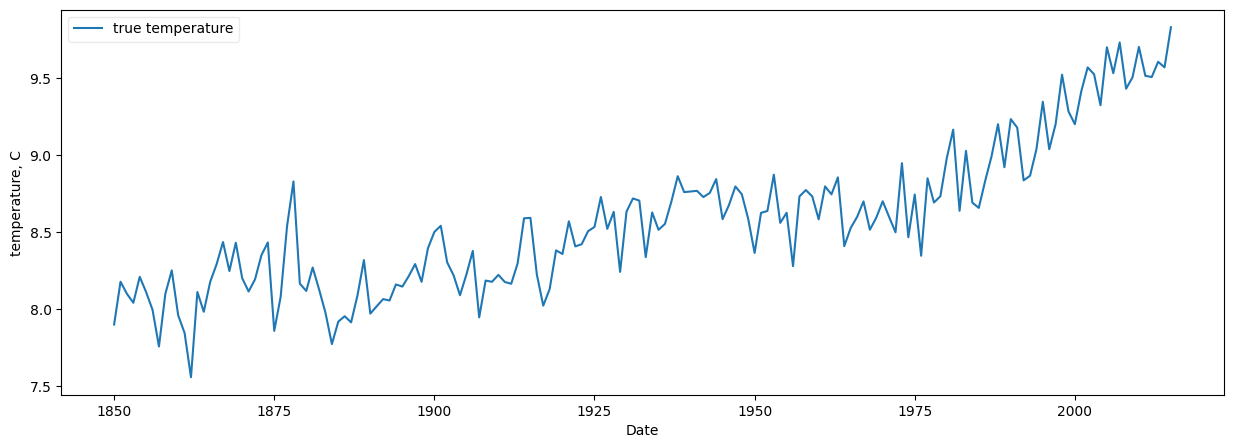

In [77]:
def plot_temps(time, data, prediction=None):
    plt.figure(figsize=(15,5))
    plt.plot(time, data, label="true temperature")

    if not (prediction is None):
        plt.plot(time, prediction, label="predicted temperature")

    plt.xlabel("Date")
    plt.ylabel("temperature, C")
    plt.legend(framealpha=0.4)
    plt.show()

plot_temps(year_data["year"], year_data["avg_temp"])


<!-- Yearly data: Least squares for linear regression -->

## 3. Linear trend for yearly temperature

### **3.1 (0.3 pts)** Find the linear trend for temepratures by solving the corresponding least square problem

In [78]:
def RMSE(predicted, reference):
    return np.sqrt(np.mean((predicted - reference)**2))

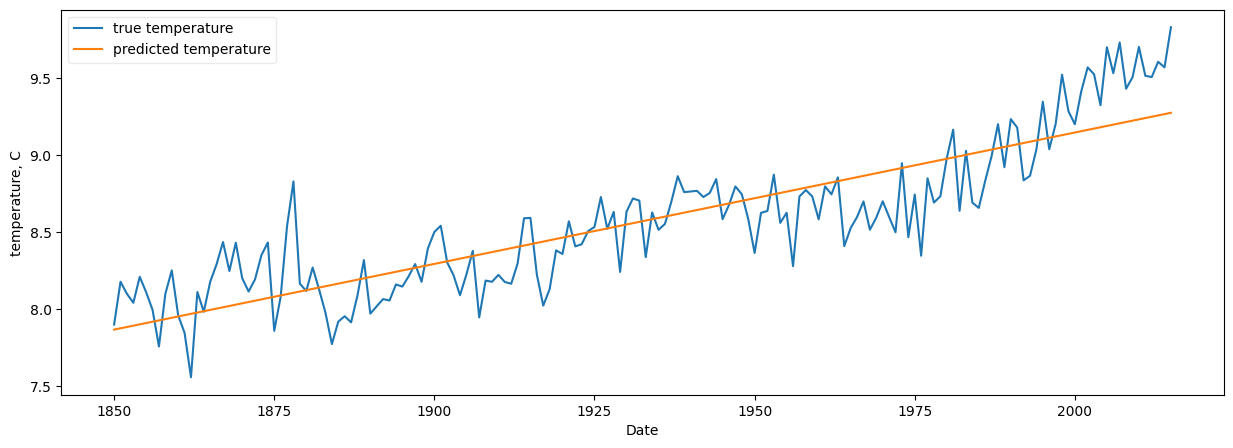

RMSE:  0.23640974195999212


In [79]:
years = np.arange(year_data.shape[0])
slope = None
intercept = None
# ========= YOUR CODE STARTS HERE ========= #
#  Calculate slope and intercept using the function 'solve_least_squares'
slope, intercept = solve_least_squares(year_data["year"], year_data["avg_temp"])
# Predict temperature using a linear model
predicted_temps = slope * year_data["year"] + intercept
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(year_data["year"], year_data["avg_temp"], predicted_temps)
print("RMSE: ", RMSE(predicted_temps, year_data["avg_temp"]))

## 4. Multilinear regression

In a more general case, we want to represent our target variable as a linear combination of several predictors:
$$ y = a_0 + a_1x_1 + a_2x_2+ \dots + a_nx_n$$


### **4.1 (0.3 pts)** Explain how to apply the least squares method in order to obtain the coefficients $( a_0, a_1, ..., a_n )$ that minimize the sum of squared residuals
$$ \sum_{j=1}^N |y_j - a_0 - a_1x_{1,j} - a_2x_{2,j} - \dots - a_nx_{n,j}|^2 $$

---

\### Represent the equation in matrix form using matrices and vectors. In matrix form, the equation becomes:

$Y=X⋅A+E$

where:

- Y is a column vector of the observed values of the target variable.
- X is a matrix where each row represents an observation, and each column corresponds to a predictor variable.
- A is a column vector containing the coefficients a0,a1,…,ana0​,a1​,…,an​.
- E is a column vector representing the error terms or residuals.


To find the coefficients that minimize the sum of squared residuals, use the normal equation to solve for A in the equation $X^TXA=X^TY$ => 

$A = (X^TX)^{-1} * X^TY$ \###

---

### **4.2 (0.4 pts)** Implement multilinear regression in the chunks below

In [80]:
def solve_least_squares_general(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Args:
        X: 2D array (x_1, x_2, ..., x_n) of basis variables
        y: 1D array of responses
    Returns:
        Coeffs: slope for each variable in X and intercept
    """
    assert X.ndim == 2
    assert X.shape[0] == y.shape[0]
    assert y.ndim == 1

    # Add a column of ones to X for the intercept term
    X = np.column_stack([np.ones(X.shape[0]), X])

    # Calculate the coefficients using the normal equation
    coeffs = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    return coeffs


In [81]:

def predict_general(X: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """
    Predicts the values of the response variable based on the coefficients and predictor variables.

    Args:
        X: 2D array (x_1, x_2, ..., x_n) of basis variables
        coeffs: Slope for each variable in X and intercept

    Returns:
        y_pred: Predicted values
    """
    assert X.ndim == 2
    assert coeffs.ndim == 1
    assert coeffs.shape[0] == X.shape[1] + 1  # slope for each x + intercept

    # Add a column of ones to X for the intercept term
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])

    # Calculate predicted values y_pred = X_with_intercept * coeffs
    y_pred = X_with_intercept.dot(coeffs)

    return y_pred


In [82]:
def test_solve_least_squares_general():
    x1 = np.arange(1, 10)
    x2 = x1**2
    y = 1 + 3*x1 + 2*x2
    X = np.array([ x1, x2 ])

    coeffs = solve_least_squares_general(X.T, y)
    assert np.isclose(coeffs, np.array([1, 3, 2])).all(), 'Incorrect coefficients computed'
    print("TEST 2: SUCCESS")

test_solve_least_squares_general()

TEST 2: SUCCESS


## 5. Linear structural dependence

In a more general case, we want to represent our target variable as a linear combination of some basis (possibly non-linear) functions of a scalar predictor $x$:
$$ F(x) = a_0 + a_1f_1(x) + a_2f_2(x)+... + a_nf_n(x)$$

### **5.1 (0.3 pts)** Explain how to apply the least squares method in this case to find the optimal coefficients $( a_0, a_1, ..., a_n )$.

---

\### 
We don't really need to change something when we have some functions f, the only thing we need to be aware is that features $f_1(x), ..., f_n(x)$ should not be lineary independent, and then everything is solved in the same way as with features $x_1,...x_n$, just by denoting $f_i(x)$ as $x_i(x)$.
\###

---

### **5.2 (0.3 pts)** Solve the previous problem using 2 basis functions $f_1(x) = x$ and $f_2(x) = x^2$. Compare the accuracy with the previous model

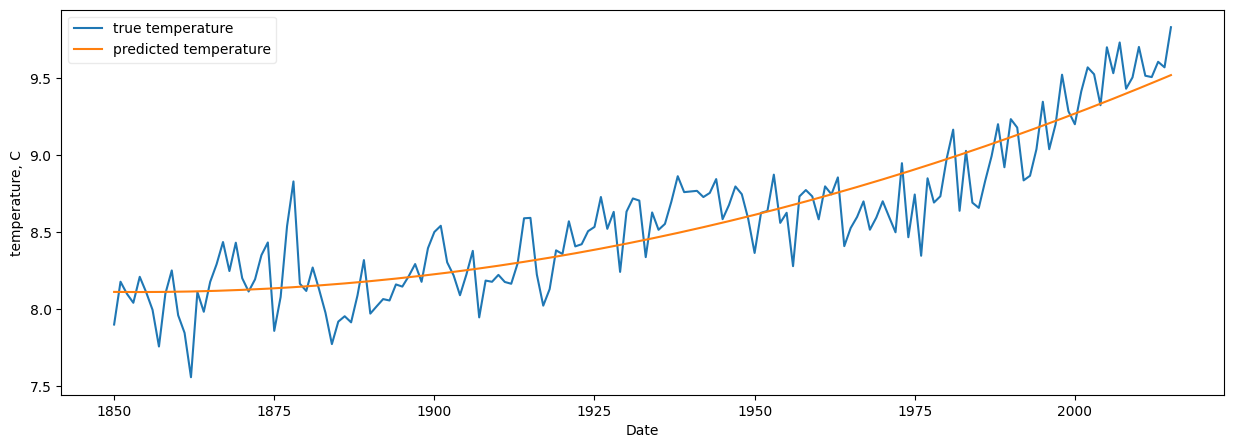

RMSE:  0.20849333659587033


In [84]:
# print(months.shape, biases.shape, year_data.shape)
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X = np.column_stack([year_data["year"], year_data["year"] ** 2])
#  Calculate slope and intercept using least squares
coeffs = solve_least_squares_general(X, year_data["avg_temp"])
# Predict temperature using a linear structural model
predicted_temps = predict_general(X, coeffs)
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(year_data["year"], year_data["avg_temp"], predicted_temps)

print("RMSE: ", RMSE(predicted_temps, year_data["avg_temp"]))


We see that quadratic polynomial fits the data better, than linear one, we also can conclude this based on RMSE metric.

## 6. Modelling monthly temperatures

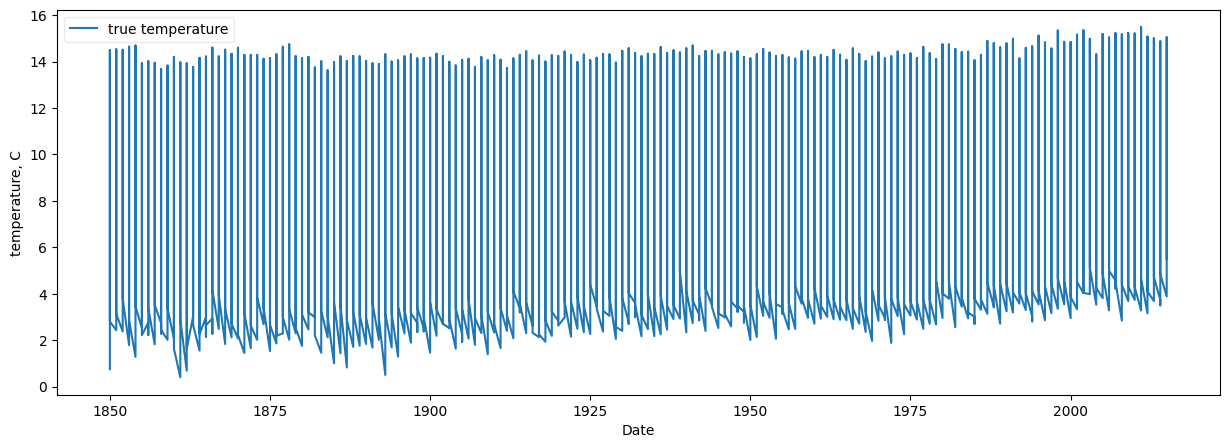

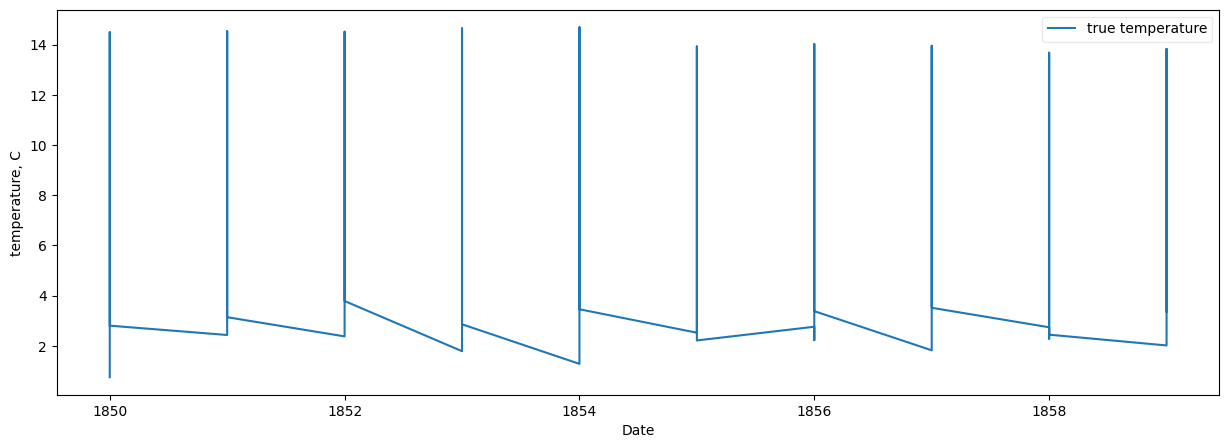

In [85]:
# Let's try to predict temperature on a monthly basis
plot_temps(temp_data["date"].map(lambda x : x.year), temp_data["avg_temp"])
# Look at the first 10 for better resolution
plot_temps(temp_data[:120]["date"].map(lambda x : x.year), temp_data[:120]["avg_temp"])

### **6.1 (0.4 pts)**

We see periodical dependence in the monthly temperatures, so let's fit linear structural model with periodical functions: $$\begin{align*}f_1(x)&=\sin\bigg(\frac{2\pi x}{T}\bigg) \\ f_2(x)&=\cos\bigg(\frac{2\pi x}{T}\bigg)\end{align*}$$ where $T=12$ is the period in months

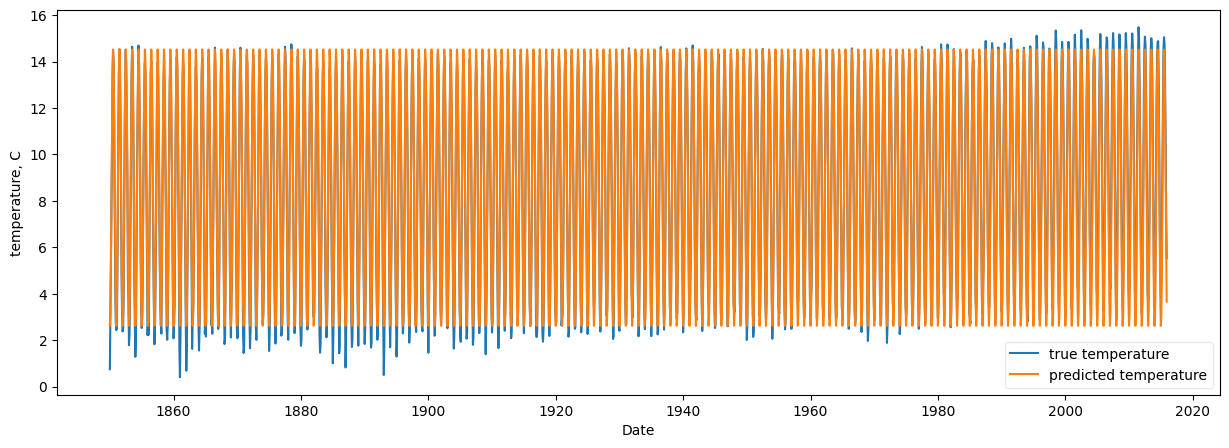

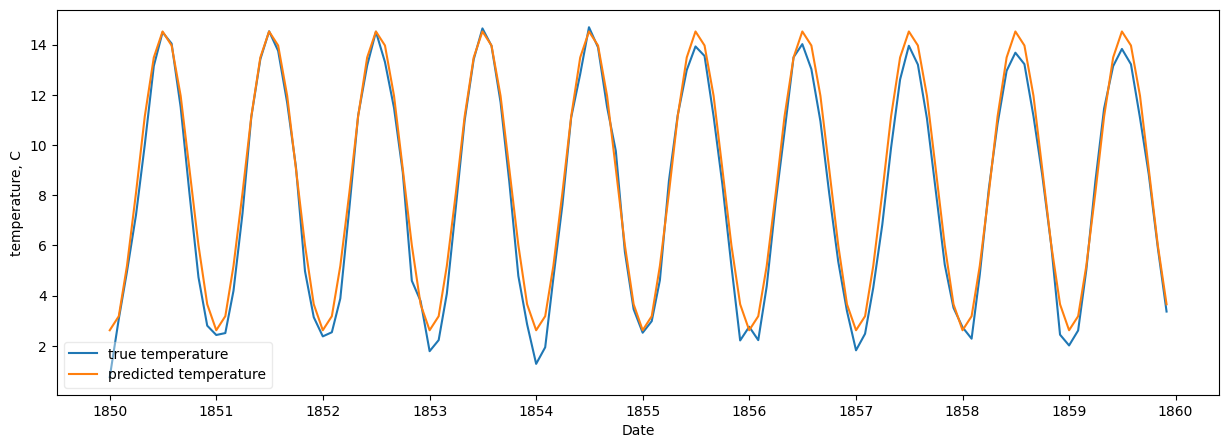

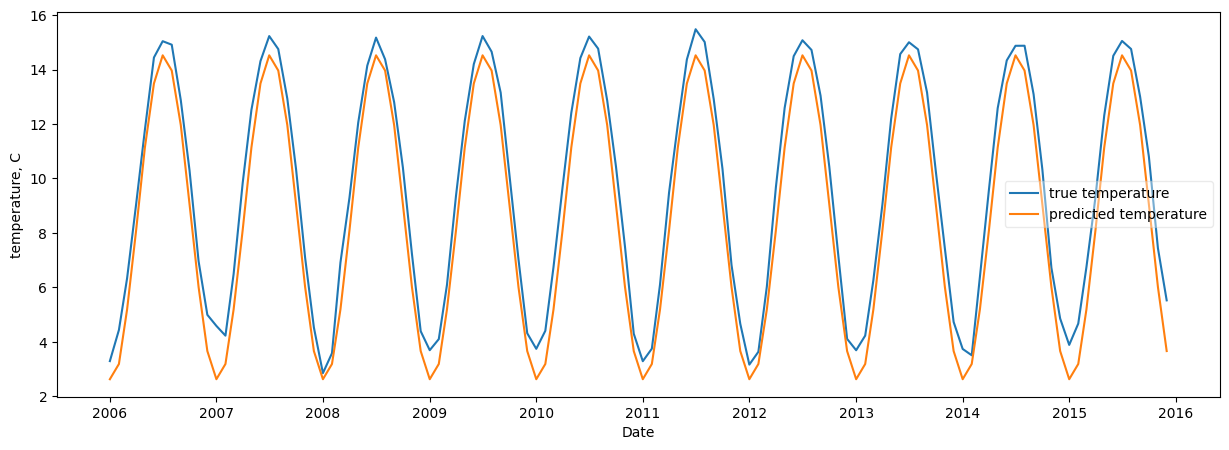

RMSE:  0.5848254249227474


In [86]:
# We see periodical dependence, so let's try least squares with periodical functions: f1=sin(2*pi*x/T), f2=cos(2*pi*x/T)
# Where T=12 is a period in months
T = 12
months = np.arange(temp_data.shape[0])
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X_month =  np.column_stack([np.sin(2 * np.pi * months / T), np.cos(2 * np.pi * months / T)])
#  Calculate slope and intercept using least squares
coeffs = solve_least_squares_general(X_month, temp_data["avg_temp"])
# Predict temperature using a linear model
predicted_temps = predict_general(X_month, coeffs)
# ========== YOUR CODE ENDS HERE ========== #

# Make conclusions about the fit accuracy
plot_temps(temp_data["date"], temp_data["avg_temp"], predicted_temps)
# First 10 years:
plot_temps(temp_data["date"][:120], temp_data["avg_temp"][:120], predicted_temps[:120])
# Last 10 years:
plot_temps(temp_data["date"][-120:], temp_data["avg_temp"][-120:], predicted_temps[-120:])

print("RMSE: ", RMSE(predicted_temps, temp_data["avg_temp"]))


## 7. Combining the results

### **7.1 (0.3 pts)** Combine the basis functions used in two previous tasks to get an even better result

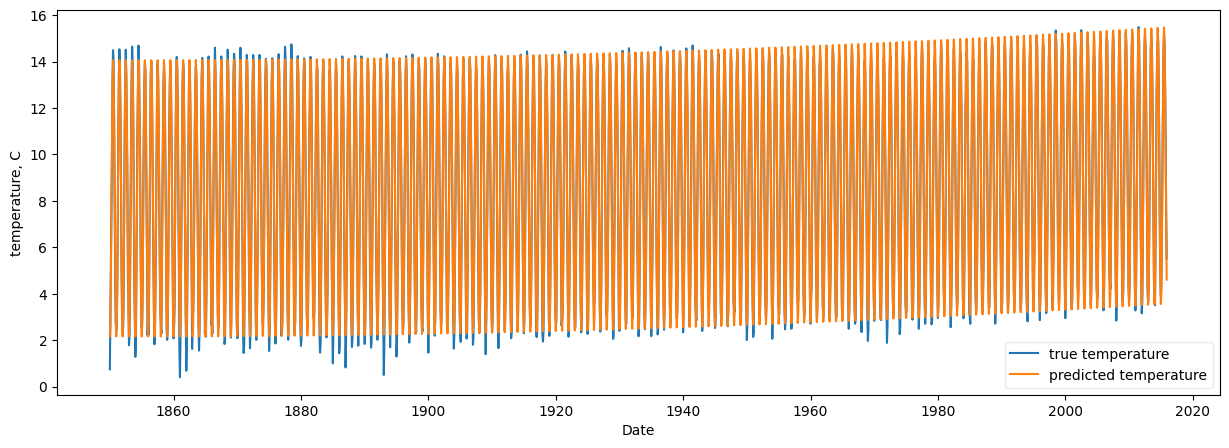

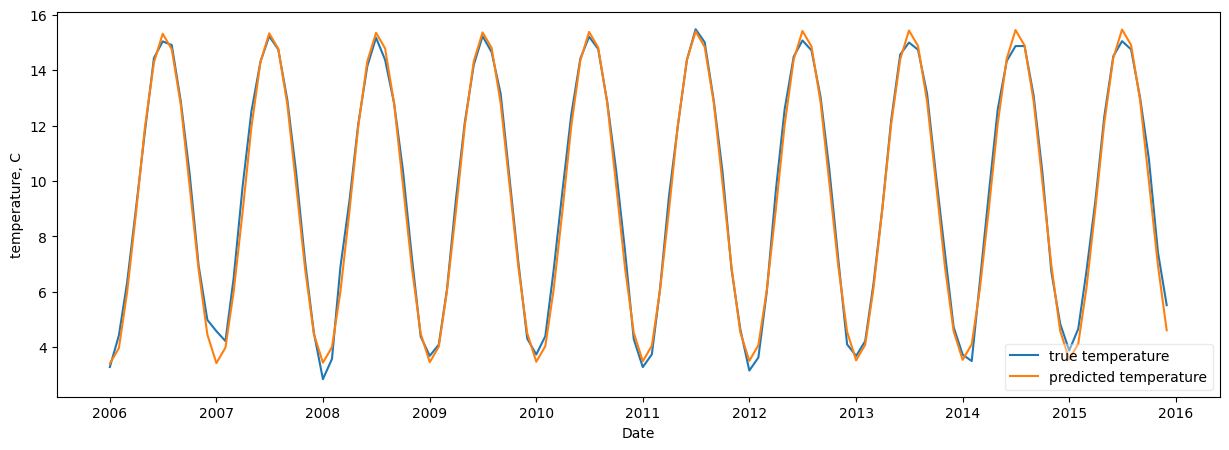

RMSE:  0.4030948513969517


In [87]:
months = np.arange(temp_data.shape[0])
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X_month = np.column_stack([
    np.arange(temp_data.shape[0]),  # Linear function f1(x) = x
    np.arange(temp_data.shape[0]) ** 2,  # Quadratic function f2(x) = x^2
    np.sin(2 * np.pi * np.arange(temp_data.shape[0]) / T),  # Periodic function f3(x) = sin(2*pi*x/T)
    np.cos(2 * np.pi * np.arange(temp_data.shape[0]) / T)   # Periodic function f4(x) = cos(2*pi*x/T)
])
#  Calculate slope and intercept using least squares
coeffs = solve_least_squares_general(X_month, temp_data["avg_temp"])
# Predict temperature using a linear model
predicted_temps = predict_general(X_month, coeffs)
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(temp_data["date"], temp_data["avg_temp"], predicted_temps)
# Last 10 years:
plot_temps(temp_data["date"][-120:], temp_data["avg_temp"][-120:], predicted_temps[-120:])

print("RMSE: ",  RMSE(predicted_temps, temp_data["avg_temp"]))


## 8. Summary (0.4 pts)

---

Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---


This task helped us understand and apply linear regression using various basis functions to analyze temperature data. We learned to incorporate linear, quadratic, and periodic functions into the regression model, observing how they captured complex data patterns. This highlighted the crucial need to collaboratively select appropriate basis functions to ensure precise modeling when using linear regression.

Throughout this assignment, we have made a couple of models, that had different precisions in capturing data and also combined them to achieve even better results.